In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from util import *
from threading import Thread

species = {
    "Streptococcus parasanguinis",
    "Veillonella parvula",
    "Neisseria subflava",
    "Prevotella nigrescens",
    "Streptococcus mitis",
    "Haemophilus parainfluenzae",
    "Schaalia odontolytica",
    "Rothia dentocariosa",
    "Streptococcus salivarius",
    "Fusobacterium nucleatum",
    "Streptococcus mutans",
    "Porphyromonas gingivalis"}

total = 1_140_052

In [9]:
# read in all data from the dataset.tsv and the paths given there
# read tree
tree = Tree("F:/Studium/Master/semester5/thesis/data/NCBI/taxdmp/tree_nr.txt")
true_taxons = get_true_taxons_for_all_ranks(tree, species)
# read in all results that have been generated so far
data = pd.read_csv("datasets_zymo_oral.tsv", sep="\t", header=0).fillna("")
# define algorithms that should be included in the dataframe
algorithms = ["OVO (1.00) read count cumulative"]
for i, row in data.iterrows():
    # read per taxon assignment files and keep taxa with at least one read assigned by the "OVO (1.00) read count cumulative" algorithm
    per_taxon_assignment = read_per_taxon_assignment(row.path, kmer_threshold=0, ovo_1_threshold=1)
    # filter for taxa that are known to be in the sample and sum up the (true) assigned reads per taxonomic rank
    per_taxon_assignment = per_taxon_assignment.loc[[label for labels in true_taxons.values() for label in labels if label in per_taxon_assignment.index]].groupby("rank").sum()
    # transform the data frame to have the taxonomic rank and algorithm as columns
    per_taxon_assignment = pd.melt(per_taxon_assignment.reset_index(), id_vars="rank", value_vars=algorithms, var_name="algorithm", value_name="true assigned reads")
    # add a column that combines the taxonomic rank and algorithm in one label
    per_taxon_assignment["rank, algorithm"] = per_taxon_assignment["rank"] + ", " + per_taxon_assignment["algorithm"]
    # add the true assigned reads per taxon-algorithm combination to the data frame
    data.loc[i, per_taxon_assignment["rank, algorithm"].values] = per_taxon_assignment["true assigned reads"].values
# save dataframe
data.to_csv("datasets_zymo_oral_with_results.tsv", sep="\t", index=False)
data

,database,alphabet,kmer size,seed shape,minimizer window,filtering,path,minimizer criterion,DB Index size,"class, OVO (1.00) read count cumulative","family, OVO (1.00) read count cumulative","genus, OVO (1.00) read count cumulative","kingdom, OVO (1.00) read count cumulative","order, OVO (1.00) read count cumulative","phylum, OVO (1.00) read count cumulative","species, OVO (1.00) read count cumulative","superkingdom, OVO (1.00) read count cumulative"
0,kraken2 - NR,Solis 15 S,12,111111111111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,,,1136476.0,1134365.0,1132097.0,589907.0,1134896.0,1139112.0,812985.0,1139424.0
1,NR90,uniform 11 S,11,11111111111,11,,F:/Studium/Master/semester5/thesis/data/test_d...,,238.0,1126660.0,1097797.0,1089099.0,1139089.0,1100032.0,1138798.0,442088.0,1139753.0
2,NR90,uniform 11 S,12,111111111111,12,,F:/Studium/Master/semester5/thesis/data/test_d...,,268.0,1128878.0,1118611.0,1106866.0,1138901.0,1120697.0,1138480.0,448565.0,1139504.0
3,NR90,uniform 11 S,13,1111111111111,13,,F:/Studium/Master/semester5/thesis/data/test_d...,,279.0,1128596.0,1119989.0,1107578.0,1137657.0,1122114.0,1137331.0,449634.0,1138301.0
4,NR90,uniform 11 S,14,11111111111111,14,,F:/Studium/Master/semester5/thesis/data/test_d...,,286.0,1128725.0,1120291.0,1107380.0,1135961.0,1122462.0,1135604.0,449958.0,1137086.0
5,NR90,uniform 11 S,15,111111111111111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,,292.0,1128918.0,1120338.0,1106946.0,1135276.0,1122619.0,1134881.0,448896.0,1136815.0
6,NR90,uniform 11 S,12,111010110100110111,18,,F:/Studium/Master/semester5/thesis/data/test_d...,,271.0,1132568.0,1120595.0,1108433.0,1137399.0,1122819.0,1136292.0,442364.0,1138451.0


In [2]:
# read in only the new data
# read tree
tree = Tree("F:/Studium/Master/semester5/thesis/data/NCBI/taxdmp/tree_nr.txt")
true_taxons = get_true_taxons_for_all_ranks(tree, species)
# read in all results that have been generated so far
data = pd.read_csv("datasets_zymo_oral.tsv", sep="\t", header=0).fillna("")
# read in existing data:
data_processed = pd.read_csv("datasets_zymo_oral_with_results.tsv", sep="\t", header=0).fillna("")
# define algorithms that should be included in the dataframe
algorithms = ["OVO (1.00) read count cumulative"]
for i, row in data.iterrows():
    # check if the row is already in the processed data
    if row.path in data_processed.path.values:
        continue
    else:
        # add the row to the processed data
        data_processed = pd.concat([data_processed, row.to_frame().T], ignore_index=True)

    # read per taxon assignment files and keep taxa with at least one read assigned by the "OVO (1.00) read count cumulative" algorithm
    per_taxon_assignment = read_per_taxon_assignment(row.path, kmer_threshold=0, ovo_1_threshold=1)
    # filter for taxa that are known to be in the sample and sum up the (true) assigned reads per taxonomic rank
    per_taxon_assignment = per_taxon_assignment.loc[[label for labels in true_taxons.values() for label in labels if label in per_taxon_assignment.index]].groupby("rank").sum()
    # transform the data frame to have the taxonomic rank and algorithm as columns
    per_taxon_assignment = pd.melt(per_taxon_assignment.reset_index(), id_vars="rank", value_vars=algorithms, var_name="algorithm", value_name="true assigned reads")
    # add a column that combines the taxonomic rank and algorithm in one label
    per_taxon_assignment["rank, algorithm"] = per_taxon_assignment["rank"] + ", " + per_taxon_assignment["algorithm"]
    # add the true assigned reads per taxon-algorithm combination to the data frame
    data_processed.loc[len(data_processed) - 1, per_taxon_assignment["rank, algorithm"].values] = per_taxon_assignment["true assigned reads"].values
data = data_processed
# save dataframe
data.to_csv("datasets_zymo_oral_with_results.tsv", sep="\t", index=False)
data

,database,alphabet,kmer size,seed shape,minimizer window,filtering,path,minimizer criterion,DB Index size,"class, OVO (1.00) read count cumulative","family, OVO (1.00) read count cumulative","genus, OVO (1.00) read count cumulative","kingdom, OVO (1.00) read count cumulative","order, OVO (1.00) read count cumulative","phylum, OVO (1.00) read count cumulative","species, OVO (1.00) read count cumulative","superkingdom, OVO (1.00) read count cumulative"
0,NR90,uniform 11 S,11,11111111111,11,,F:/Studium/Master/semester5/thesis/data/test_d...,,238.0,1126660.0,1097797.0,1089099.0,1139089.0,1100032.0,1138798.0,442088.0,1139753.0
1,NR90,uniform 11 S,12,111111111111,12,,F:/Studium/Master/semester5/thesis/data/test_d...,,268.0,1128878.0,1118611.0,1106866.0,1138901.0,1120697.0,1138480.0,448565.0,1139504.0
2,NR90,uniform 11 S,14,11111111111111,14,,F:/Studium/Master/semester5/thesis/data/test_d...,,286.0,1128725.0,1120291.0,1107380.0,1135961.0,1122462.0,1135604.0,449958.0,1137086.0
3,NR90,uniform 11 S,15,111111111111111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,,292.0,1128918.0,1120338.0,1106946.0,1135276.0,1122619.0,1134881.0,448896.0,1136815.0
4,NR90,uniform 11 S,12,111010110100110111,18,,F:/Studium/Master/semester5/thesis/data/test_d...,,271.0,1132568.0,1120595.0,1108433.0,1137399.0,1122819.0,1136292.0,442364.0,1138451.0
5,NR90,uniform 11 S,9,110110101000111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,,147.0,537129.0,24334.0,12413.0,1128586.0,27743.0,1113023.0,1569.0,1138966.0
6,NR90,uniform 11 S,12,11111100111111,14,,F:/Studium/Master/semester5/thesis/data/test_d...,,269.0,1131650.0,1120609.0,1108597.0,1138394.0,1122679.0,1137747.0,447269.0,1139164.0
7,NR90,uniform 16 S,13,1111111111111,13,,F:/Studium/Master/semester5/thesis/data/test_d...,,284.0,1127922.0,1120010.0,1107479.0,1137015.0,1121835.0,1136855.0,451168.0,1137577.0
8,NR,uniform 16 S,13,1111111111111,13,,F:/Studium/Master/semester5/thesis/data/test_d...,,629.0,1136298.0,1131466.0,1129876.0,1138959.0,1132164.0,1138669.0,826447.0,1139427.0
9,NR90,uniform 11 S,13,1111111111111,13,c > 3,F:/Studium/Master/semester5/thesis/data/test_d...,,279.0,1128596.0,1119989.0,1107578.0,1137657.0,1122114.0,1137331.0,449634.0,1138301.0


C:\Users\noel\AppData\Local\Temp\ipykernel_11920\3308915469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_all_nr["label"] = select_all_nr["alphabet"] + " " + select_all_nr["kmer size"].astype(str) + " " + select_all_nr["minimizer window"].astype(str) + " " + select_all_nr["minimizer criterion"] + " " + select_all_nr["filtering"]


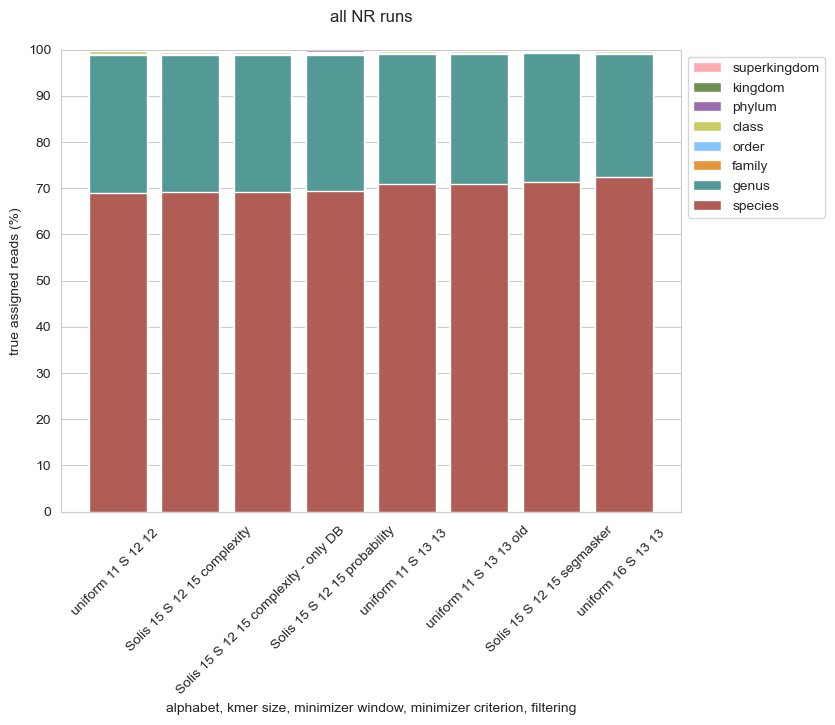

,database,alphabet,kmer size,seed shape,minimizer window,filtering,path,minimizer criterion,DB Index size,class,family,genus,kingdom,order,phylum,species,superkingdom,label
17,NR,uniform 11 S,12,111111111111,12,,F:/Studium/Master/semester5/thesis/data/test_d...,,302.0,1136829.0,1127812.0,1126210.0,1139488.0,1128639.0,1139217.0,786127.0,1139912.0,uniform 11 S 12 12
11,NR,Solis 15 S,12,111111111111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,complexity,128.0,1135389.0,1129346.0,1127235.0,1138474.0,1130167.0,1137617.0,788929.0,1139646.0,Solis 15 S 12 15 complexity
12,NR,Solis 15 S,12,111111111111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,complexity - only DB,128.0,1135389.0,1129346.0,1127235.0,1138474.0,1130167.0,1137617.0,788929.0,1139646.0,Solis 15 S 12 15 complexity - only DB
13,NR,Solis 15 S,12,111111111111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,probability,184.0,1134220.0,1129710.0,1127698.0,1138540.0,1130602.0,1138007.0,790377.0,1139560.0,Solis 15 S 12 15 probability
15,NR,uniform 11 S,13,1111111111111,13,,F:/Studium/Master/semester5/thesis/data/test_d...,,369.0,1136366.0,1131224.0,1129457.0,1139179.0,1131997.0,1138845.0,807610.0,1139633.0,uniform 11 S 13 13
14,NR,uniform 11 S,13,1111111111111,13,,F:/Studium/Master/semester5/thesis/data/test_d...,old,611.0,1136374.0,1131235.0,1129468.0,1139186.0,1132001.0,1138856.0,807735.0,1139632.0,uniform 11 S 13 13 old
16,kraken2 - NR,Solis 15 S,12,111111111111,15,,F:/Studium/Master/semester5/thesis/data/test_d...,segmasker,,1136476.0,1134365.0,1132097.0,589907.0,1134896.0,1139112.0,812985.0,1139424.0,Solis 15 S 12 15 segmasker
8,NR,uniform 16 S,13,1111111111111,13,,F:/Studium/Master/semester5/thesis/data/test_d...,,629.0,1136298.0,1131466.0,1129876.0,1138959.0,1132164.0,1138669.0,826447.0,1139427.0,uniform 16 S 13 13


In [4]:
# all NR runs
select_all_nr = data.loc[((data["database"] == "NR") | (data["database"] == "kraken2 - NR"))]
select_all_nr["label"] = select_all_nr["alphabet"] + " " + select_all_nr["kmer size"].astype(str) + " " + select_all_nr["minimizer window"].astype(str) + " " + select_all_nr["minimizer criterion"] + " " + select_all_nr["filtering"]
select_all_nr = select_all_nr.rename(columns=lambda x: x.replace(", OVO (1.00) read count cumulative","")).sort_values(by=["species"])
plot_true_assigned_per_rank(select_all_nr, total, "all NR runs", "alphabet, kmer size, minimizer window, minimizer criterion, filtering")
select_all_nr

C:\Users\nk035\AppData\Local\Temp\ipykernel_10328\3921702116.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_different_filtering_nr90["label"] = select_different_filtering_nr90["filtering"]


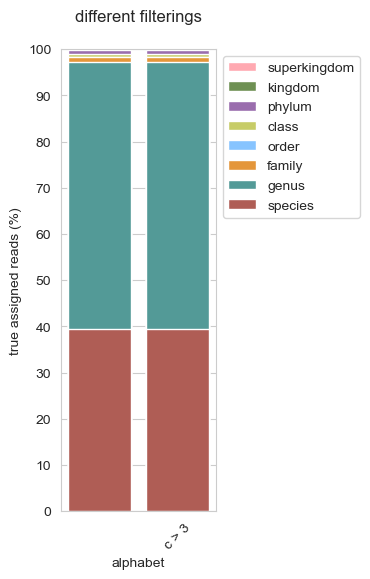

,database,alphabet,kmer size,seed shape,minimizer window,filtering,path,minimizer criterion,DB Index size,class,family,genus,kingdom,order,phylum,species,superkingdom,label
12,NR90,uniform 11 S,13,1111111111111,13,,F:/Studium/Master/semester5/thesis/data/test_d...,,171.0,1128585.0,1119967.0,1107561.0,1137621.0,1122092.0,1137293.0,449620.0,1138263.0,
11,NR90,uniform 11 S,13,1111111111111,13,c > 3,F:/Studium/Master/semester5/thesis/data/test_d...,,279.0,1128596.0,1119989.0,1107578.0,1137657.0,1122114.0,1137331.0,449634.0,1138301.0,c > 3


In [4]:
# filtering nr90 uniform 11 S k = 13
select_different_filtering_nr90 = data.loc[(data["database"] == "NR90") & (data["kmer size"] == 13) & (data["alphabet"] == "uniform 11 S")]
select_different_filtering_nr90["label"] = select_different_filtering_nr90["filtering"]
select_different_filtering_nr90 = select_different_filtering_nr90.rename(columns=lambda x: x.replace(", OVO (1.00) read count cumulative","")).sort_values(by=["species"])
plot_true_assigned_per_rank(select_different_filtering_nr90, total, "different filterings", "alphabet")
select_different_filtering_nr90

In [0]:
# different alphabets
select_different_alphabets_nr90 = data.loc[(data["database"] == "NR90") & (data["kmer size"] == 13) & (data["filtering"] == "") & (data["minimizer criterion"] == "")]
select_different_alphabets_nr90["label"] = select_different_alphabets_nr90["alphabet"]
select_different_alphabets_nr90 = select_different_alphabets_nr90.rename(columns=lambda x: x.replace(", OVO (1.00) read count cumulative","")).sort_values(by=["species"])
plot_true_assigned_per_rank(select_different_alphabets_nr90, total, "different alphabets NR90", "alphabet")

C:\Users\nk035\AppData\Local\Temp\ipykernel_10328\1558898946.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_kraken2_vs_diamer["label"] = select_kraken2_vs_diamer["database"] + select_kraken2_vs_diamer["alphabet"]


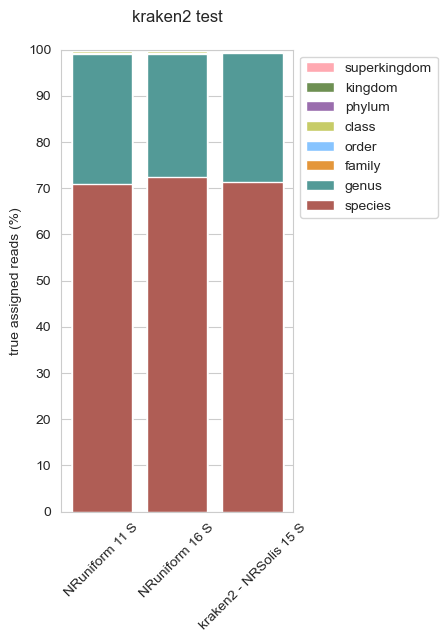

In [5]:
# kraken2 vs diamer2 result
select_kraken2_vs_diamer = data.loc[(data["database"] == "kraken2 - NR") | (data["database"] == "NR")]
select_kraken2_vs_diamer["label"] = select_kraken2_vs_diamer["database"] + select_kraken2_vs_diamer["alphabet"]
select_kraken2_vs_diamer = select_kraken2_vs_diamer.rename(columns=lambda x: x.replace(", OVO (1.00) read count cumulative","")).sort_values(by=["label"])
plot_true_assigned_per_rank(select_kraken2_vs_diamer, total, "kraken2 test")

C:\Users\nk035\AppData\Local\Temp\ipykernel_22892\2625793312.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_kmer_sizes_nr90_uniform["label"] = select_kmer_sizes_nr90_uniform["kmer size"]


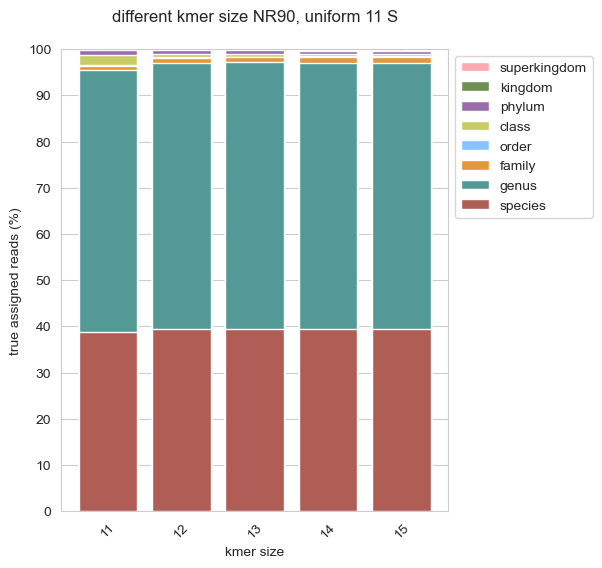

In [3]:
# different k-mer lengths
select_kmer_sizes_nr90_uniform = data.loc[(data["database"] == "NR90") & (data["filtering"] == "") & (data["alphabet"] == "uniform 11 S") & (data["kmer size"] == data["minimizer window"])]
select_kmer_sizes_nr90_uniform["label"] = select_kmer_sizes_nr90_uniform["kmer size"]
select_kmer_sizes_nr90_uniform = select_kmer_sizes_nr90_uniform.rename(columns=lambda x: x.replace(", OVO (1.00) read count cumulative","")).sort_values(by=["label"])
plot_true_assigned_per_rank(select_kmer_sizes_nr90_uniform, total, "different kmer size NR90, uniform 11 S", x_axis="kmer size")

In [0]:
# different seeds
select_seed_shapes_nr90_uniform = data.loc[(data["database"] == "NR90") & (data["filtering"] == "") & (data["alphabet"] == "uniform 11 S")]
select_seed_shapes_nr90_uniform["label"] = select_seed_shapes_nr90_uniform["kmer size"].astype(str) + " " + select_seed_shapes_nr90_uniform["minimizer window"].astype(str)
select_seed_shapes_nr90_uniform = select_seed_shapes_nr90_uniform.rename(columns=lambda x: x.replace(", OVO (1.00) read count cumulative","")).sort_values(by=["species"])
plot_true_assigned_per_rank(select_seed_shapes_nr90_uniform, total, "different kmer size NR90, uniform 11 S")